In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import plotly.express as px

DATA = Path("../data/processed/analytics_table.parquet")
FIGS = Path("../reports/figures")
FIGS.mkdir(parents=True, exist_ok=True)

def save_fig(fig, path: Path, *, scale: int = 2) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    fig.write_image(str(path), scale=scale)

In [9]:

import pandas as pd

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)
pd.set_option("display.max_colwidth", None)

df = pd.read_parquet(DATA)

print("Rows:", len(df))
print("Columns:", len(df.columns))
print("\nMissing values (top):")
print(df.isna().sum().sort_values(ascending=False))

df_view = (
    df[
        [
            "order_id",
            "user_id",
            "country",
            "status",
            "status_clean",
            "amount",
            "amount__isna",
            "amount_winsor",
            "amount__is_outlier",
            "quantity",
            "quantity__isna",
            "created_at",
            "month",
        ]
    ]
    .sort_values("created_at")
    .reset_index(drop=True)
)

df_view


Rows: 30
Columns: 18

Missing values (top):
quantity              6
amount                6
amount__is_outlier    6
amount_winsor         6
hour                  5
dow                   5
month                 5
year                  5
created_at            5
date                  5
signup_date           3
order_id              0
user_id               0
status                0
quantity__isna        0
amount__isna          0
status_clean          0
country               0
dtype: int64


,order_id,user_id,country,status,status_clean,amount,amount__isna,amount_winsor,amount__is_outlier,quantity,quantity__isna,created_at,month
0,A0001,0001,SA,Paid,paid,12.5,False,12.5,False,1,False,2025-08-05 10:05:00+00:00,2025-08
1,A0002,0002,SA,paid,paid,8.0,False,8.92,False,2,False,2025-08-12 11:10:00+00:00,2025-08
2,A0003,0003,AE,Refund,refund,<NA>,True,<NA>,<NA>,1,False,2025-08-20 09:00:00+00:00,2025-08
3,A0004,0001,SA,PAID,paid,25.0,False,25.0,False,<NA>,True,2025-08-25 14:30:00+00:00,2025-08
4,A0006,0005,AE,Paid,paid,45.75,False,45.75,False,3,False,2025-09-03 08:20:00+00:00,2025-09
5,A0007,0002,SA,pending,pending,15.0,False,15.0,False,1,False,2025-09-08 12:45:00+00:00,2025-09
6,A0008,0006,AE,paid,paid,<NA>,True,<NA>,<NA>,2,False,2025-09-15 10:15:00+00:00,2025-09
7,A0009,0003,AE,PAID,paid,67.8,False,67.8,False,<NA>,True,2025-09-22 16:30:00+00:00,2025-09
8,A0011,0001,SA,paid,paid,35.0,False,35.0,False,4,False,2025-09-28 09:10:00+00:00,2025-09
9,A0012,0008,SA,Paid,paid,90.0,False,90.0,False,1,False,2025-10-02 13:25:00+00:00,2025-10


In [4]:
#Helper Columns
if "month" not in df.columns and "created_at" in df.columns:
    dt = pd.to_datetime(df["created_at"], errors="coerce", utc=True)
    df["month"] = dt.dt.to_period("M").astype("string")

if "amount_winsor" not in df.columns and "amount" in df.columns:
    lo, hi = df["amount"].quantile([0.01, 0.99])
    df["amount_winsor"] = df["amount"].clip(lo, hi)

  country   n  revenue        aov
1      SA  17   641.85  40.115625
0      AE  13   463.05   57.88125


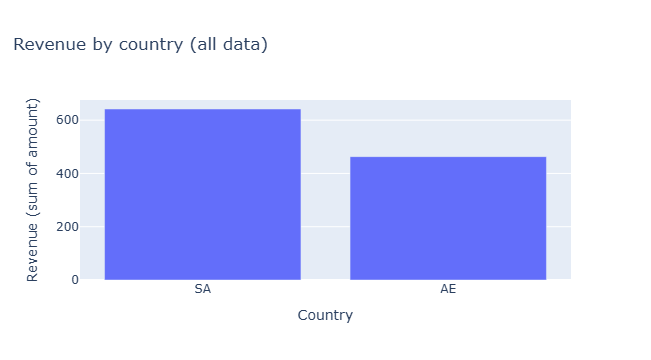

In [5]:
#Revenue by Country
rev = (
    df.groupby("country", dropna=False)
      .agg(n=("order_id", "size"), revenue=("amount", "sum"), aov=("amount", "mean"))
      .reset_index()
      .sort_values("revenue", ascending=False)
)

print(rev)

fig = px.bar(rev, x="country", y="revenue", title="Revenue by country (all data)")
fig.update_layout(title={"x": 0.02})
fig.update_xaxes(title_text="Country")
fig.update_yaxes(title_text="Revenue (sum of amount)")
save_fig(fig, FIGS / "revenue_by_country.png")
fig.show()

     month  n  revenue
0  2025-08  4     45.5
1  2025-09  5   163.55
2  2025-10  5   199.25
3  2025-11  6   197.75
4  2025-12  5   213.65
5     <NA>  5    285.2


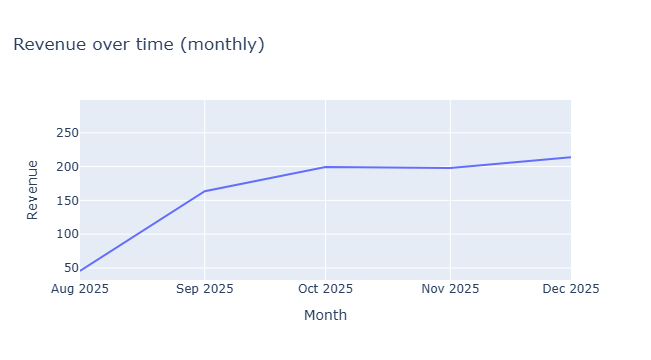

In [6]:
#Revenue Trend
trend = (
    df.groupby("month", dropna=False)
      .agg(n=("order_id", "size"), revenue=("amount", "sum"))
      .reset_index()
      .sort_values("month")
)

print(trend)

fig = px.line(trend, x="month", y="revenue", title="Revenue over time (monthly)")
fig.update_layout(title={"x": 0.02})
fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Revenue")
save_fig(fig, FIGS / "revenue_trend_monthly.png")
fig.show()

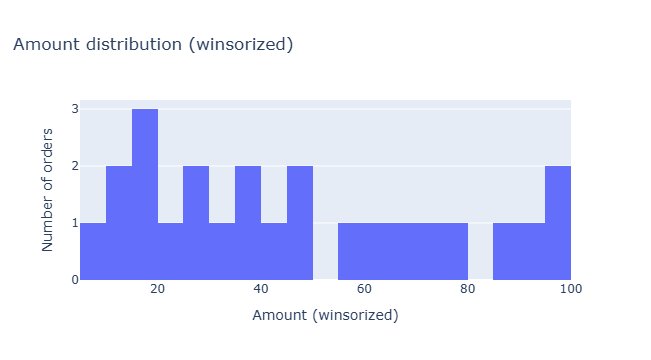

In [7]:
#Amount Distribution
fig = px.histogram(df, x="amount_winsor", nbins=30, title="Amount distribution (winsorized)")
fig.update_layout(title={"x": 0.02})
fig.update_xaxes(title_text="Amount (winsorized)")
fig.update_yaxes(title_text="Number of orders")
save_fig(fig, FIGS / "amount_hist_winsor.png")
fig.show()

In [8]:
# Bootstrap Comparison
def bootstrap_diff_means(a: pd.Series, b: pd.Series, *, n_boot: int = 2000, seed: int = 0):
    rng = np.random.default_rng(seed)
    a = pd.to_numeric(a, errors="coerce").dropna().to_numpy()
    b = pd.to_numeric(b, errors="coerce").dropna().to_numpy()
    assert len(a) > 0 and len(b) > 0

    diffs = []
    for _ in range(n_boot):
        sa = rng.choice(a, size=len(a), replace=True)
        sb = rng.choice(b, size=len(b), replace=True)
        diffs.append(sa.mean() - sb.mean())
    diffs = np.array(diffs)

    return {
        "diff_mean": float(a.mean() - b.mean()),
        "ci_low": float(np.quantile(diffs, 0.025)),
        "ci_high": float(np.quantile(diffs, 0.975)),
    }

d = df.assign(is_refund=df["status_clean"].eq("refund").astype(int))

a = d.loc[d["country"].eq("SA"), "is_refund"]
b = d.loc[d["country"].eq("AE"), "is_refund"]

print("n_SA:", len(a), "n_AE:", len(b))
res = bootstrap_diff_means(a, b, n_boot=2000, seed=0)
print(res)

n_SA: 17 n_AE: 13
{'diff_mean': 0.1583710407239819, 'ci_low': -0.09502262443438915, 'ci_high': 0.4117647058823529}
